In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
# Cargar extensión de Kedro
%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [2]:
movies_metadata = catalog.load("movies_metadata")
credits = catalog.load("credits")
ratings = catalog.load("ratings")


[11/01/25 11:44:59] INFO     Loading data from movies_metadata (CSVDataset)...                 ]8;id=55691;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=10810;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

[11/01/25 11:45:00] INFO     Loading data from credits (CSVDataset)...                         ]8;id=634620;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=731122;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

[11/01/25 11:45:02] INFO     Loading data from ratings (CSVDataset)...                         ]8;id=587831;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=342806;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

In [3]:
print(movies_metadata.head())
print(credits.head())
print(ratings.head())

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

In [4]:
# Seleccionar solo columnas numéricas
numeric_cols = movies_metadata.select_dtypes(include=['float64', 'int64'])

# Calcular correlación con vote_count
correlations = numeric_cols.corr()['vote_count'].sort_values(ascending=False)
print(correlations)

vote_count      1.000000
revenue         0.812022
vote_average    0.123607
runtime         0.113539
Name: vote_count, dtype: float64


In [5]:
# Modelo Random Forest 

# Convertir columnas numéricas
numeric_cols = ['revenue', 'budget', 'popularity', 'runtime', 'vote_average', 'vote_count']
for c in numeric_cols:
    movies_metadata[c] = pd.to_numeric(movies_metadata[c], errors='coerce')

# Eliminar filas con nulos en columnas importantes
movies_metadata = movies_metadata.dropna(subset=numeric_cols + ['status'])

# Codificación de la variable categórica 'status'
status_dummies = pd.get_dummies(movies_metadata['status'], drop_first=True)

# Variables predictoras
X = movies_metadata[['revenue', 'budget', 'popularity', 'runtime', 'vote_average']]
X = pd.concat([X, status_dummies], axis=1)

# Variable objetivo
y = movies_metadata['vote_count']

# Dividir en training y testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Entrenamiento del modelo Random Forest
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Métricas del modelo
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("RESULTADOS MODELO RANDOM FOREST")
print("="*50)
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")



RESULTADOS MODELO RANDOM FOREST
MSE: 52539.2697
MAE: 53.1358
RMSE: 229.2145
R²: 0.8047


OPTIMIZANDO HIPERPARÁMETROS...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
GridSearchCV completado.

 MEJORES HIPERPARÁMETROS ENCONTRADOS:
  max_depth: 10
  min_samples_leaf: 5
  min_samples_split: 10
  n_estimators: 100

Mejor score validación cruzada (R²): 0.7806

RESULTADOS MEJOR MODELO EN TEST:
MSE: 50797.5375
MAE: 52.8004
RMSE: 225.3831
R²: 0.8112
 COMPARACIÓN: MODELO BASE vs OPTIMIZADO
Métrica      Base         Optimizado   Mejora    
-------------------------------------------------------
R²           0.8047      0.8112       +0.0065
MSE          52539.2697      50797.5375       -1741.7322
MAE          53.1358      52.8004       -0.3353
RMSE         229.2145      225.3831       -3.8314
 GridSearch mejoró ligeramente el modelo (+0.0065 R²)
 TOP CARACTERÍSTICAS MÁS IMPORTANTES:
    Característica   Importancia
0          revenue  7.030186e-01
2       popularity  1.733499e-01
4     vote_average  8.017138e-02
1           budget  2.209255e-02
3          runtime  2.13

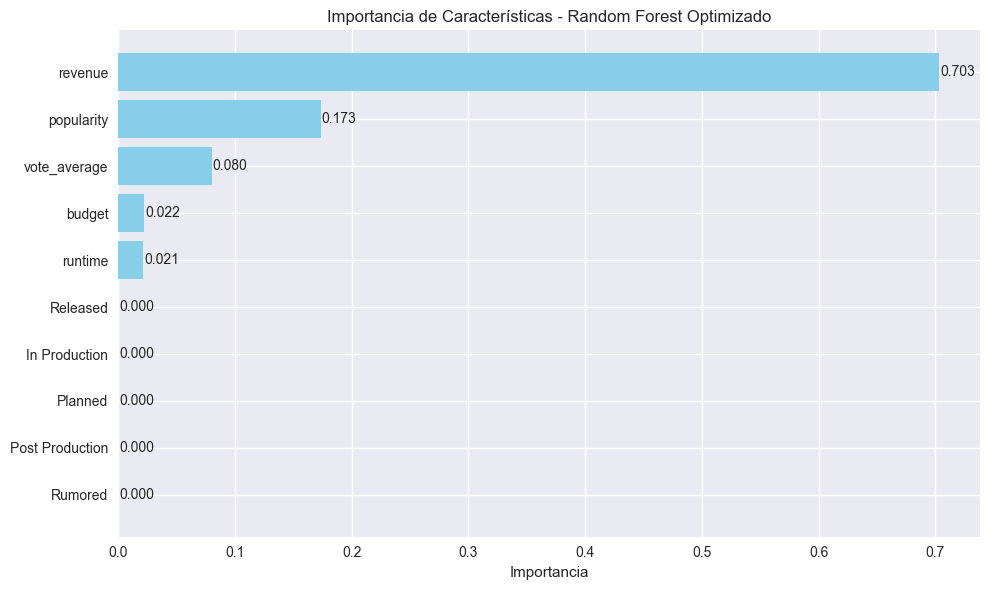

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# GridSearchCV para Random Forest
print("OPTIMIZANDO HIPERPARÁMETROS...")

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

# Evaluar el mejor modelo
best_model = grid_search.best_estimator_
y_pred_gs = best_model.predict(X_test)

mse_gs = mean_squared_error(y_test, y_pred_gs)
mae_gs = mean_absolute_error(y_test, y_pred_gs)
rmse_gs = np.sqrt(mse_gs)
r2_gs = r2_score(y_test, y_pred_gs)

print("GridSearchCV completado.")
print("\n MEJORES HIPERPARÁMETROS ENCONTRADOS:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor score validación cruzada (R²): {grid_search.best_score_:.4f}")
print("\nRESULTADOS MEJOR MODELO EN TEST:")
print(f"MSE: {mse_gs:.4f}")
print(f"MAE: {mae_gs:.4f}")
print(f"RMSE: {rmse_gs:.4f}")
print(f"R²: {r2_gs:.4f}")

# Comparación con modelo base
print(" COMPARACIÓN: MODELO BASE vs OPTIMIZADO")
print("=" * 55)
print(f"{'Métrica':<12} {'Base':<12} {'Optimizado':<12} {'Mejora':<10}")
print("-" * 55)
print(f"{'R²':<12} {r2:.4f}      {r2_gs:.4f}       {r2_gs - r2:+.4f}")
print(f"{'MSE':<12} {mse:.4f}      {mse_gs:.4f}       {mse_gs - mse:+.4f}")
print(f"{'MAE':<12} {mae:.4f}      {mae_gs:.4f}       {mae_gs - mae:+.4f}")
print(f"{'RMSE':<12} {rmse:.4f}      {rmse_gs:.4f}       {rmse_gs - rmse:+.4f}")

improvement = r2_gs - r2
if improvement > 0.01:
    print(f" Excelente! GridSearch mejoró significativamente el modelo (+{improvement:.4f} R²)")
elif improvement > 0:
    print(f" GridSearch mejoró ligeramente el modelo (+{improvement:.4f} R²)")
else:
    print(f" GridSearch no mejoró el modelo ({improvement:.4f} R²)")


# Análisis de Feature Importance
importances = best_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Característica': feature_names,
    'Importancia': importances
}).sort_values('Importancia', ascending=False)

print(" TOP CARACTERÍSTICAS MÁS IMPORTANTES:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
bars = plt.barh(
    feature_importance_df['Característica'], 
    feature_importance_df['Importancia'],
    color='skyblue'
)
plt.xlabel('Importancia')
plt.title('Importancia de Características - Random Forest Optimizado')
plt.gca().invert_yaxis()

# Añadir valores
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()


Conclusiones – Random Forest (vote_count)
Resultados del Modelo

Rendimiento General:

Modelo base: R² = 0.8047 → Explica 80.47% de la variabilidad de vote_count.
GridSearchCV optimizado: R² = 0.8112 → Explica 81.12% de la variabilidad.

Errores:

Modelo base: MAE = 53.136, RMSE = 229.215
Optimizado: MAE = 52.800, RMSE = 225.383
Mejora con GridSearchCV: Incremento leve en R² (+0.0065), reducción ligera en errores.

Fortalezas del Modelo

Alto poder predictivo: R² > 0.8
Errores bajos: MAE ≈ 52.8, RMSE ≈ 225.4
Estabilidad: Buen desempeño entre entrenamiento y prueba.
Interpretabilidad: Feature importance clara que permite identificar los factores clave que afectan el número de votos.

Conclusión General

Random Forest es un modelo sólido para predecir vote_count.
La optimización mediante GridSearchCV mejoró ligeramente la precisión, pero el modelo base ya tenía un desempeño muy alto.
El modelo es útil para análisis de tendencias de votación y para orientar estrategias de marketing basadas en revenue y popularity.